In [ ]:
#this is an implementation of close-ended pattern classification with the CLIP model
#this approach provides confidence values in cases where multiple pattern types may be present

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qnwwybaz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qnwwybaz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import clip
import numpy as np
from PIL import Image
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt
from google.colab import files
import io
import time

In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the model
model, preprocess = clip.load("ViT-B/32", device=device)
print("Model loaded successfully!")

Using device: cuda


100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.2MiB/s]


Model loaded successfully!


In [11]:
def classify_garment_pattern(image, model, preprocess, device):
    """
    Classify an image into multiple pre-defined garment pattern categories.

    Args:
        image: PIL Image object
        model: CLIP model
        preprocess: CLIP preprocessing function
        device: torch device

    Returns:
        List of dictionaries with categories and confidence scores
    """
    # Converting image to RGB
    image = image.convert("RGB")

    # Preprocessing the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Defining textual descriptions for the categories
    # Using more descriptive prompts for better image-text retrieval accuracy
    categories = ["striped clothing design pattern", "floral clothing design pattern", "solid clothing design pattern", "plaid clothing design pattern", "graphic clothing design pattern", "logo clothing design pattern", "polka dots clothing design pattern","geometric clothing design pattern","paisley clothing design pattern"]

    simple_categories = [
        "striped ", "floral", "solid", "plaid", "graphic", "logo", "polka dots","geometric", "paisley"
    ]

    text_inputs = torch.cat([clip.tokenize(desc) for desc in categories]).to(device)

    # Calculate features

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity scores
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    print(f"similarity : {similarity}")

    # Get the similarity scores for all categories
    values, indices = similarity[0].topk(len(categories))

    results = []
    for value, index in zip(values, indices):
        results.append({
            "category": simple_categories[index],
            "prompt description": categories[index],
            "confidence": float(value)
        })

    return results

In [14]:
def visualize_results(image, results):
    """
    Visualize the classification results with a bar chart.

    Args:
        image: PIL Image object
        results: List of dictionaries with categories and confidence scores
    """
    plt.figure(figsize=(14, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    # Displaying results as a bar chart
    plt.subplot(1, 2, 2)
    categories = [r["category"] for r in results]
    confidences = [r["confidence"] for r in results]

    bars = plt.bar(categories, confidences, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title("Classification Results")
    plt.ylabel("Confidence Score")
    plt.ylim(0, 1.0)

    # Adding text labels
    for bar, confidence in zip(bars, confidences):
        plt.text(bar.get_x() + bar.get_width()/2, confidence + 0.01,
                f"{confidence:.2f}", ha="center")

    plt.tight_layout()
    plt.show()

    # Printing the prediction
    top_result = results[0]
    print(f"Prediction: {top_result['category']} with {top_result['confidence']:.2%} confidence")

In [15]:
# image upload
def upload_and_classify():
    print("Please upload an image of an upper-wear garment...")
    uploaded = files.upload()

    for filename, content in uploaded.items():
        print(f"Processing {filename}...")
        image = Image.open(io.BytesIO(content))

        # Classify the image
        start_time = time.time()
        results = classify_garment_pattern(image, model, preprocess, device)
        end_time = time.time()

        print(f"Classification completed in {end_time - start_time:.2f} seconds")

        # Visualize the results
        visualize_results(image, results)

Please upload an image of an upper-wear garment...


Saving img1.png to img1.png
Processing img1.png...
similarity : tensor([[0.0078, 0.0034, 0.7046, 0.0075, 0.1727, 0.0487, 0.0009, 0.0237, 0.0305]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


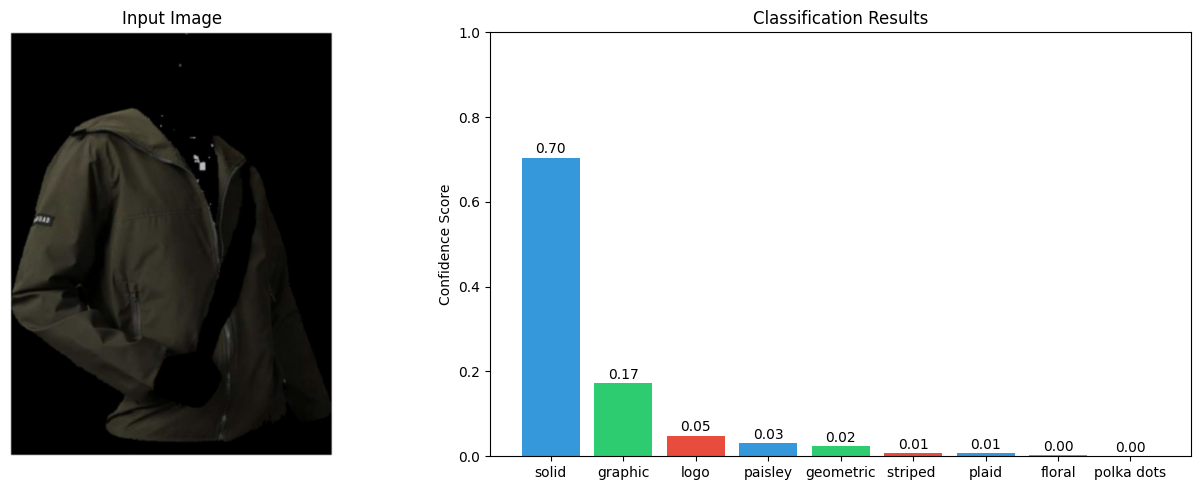

Prediction: solid with 70.46% confidence


In [16]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img2.png to img2.png
Processing img2.png...
similarity : tensor([[0.0267, 0.0085, 0.6265, 0.0307, 0.0976, 0.0848, 0.0078, 0.0583, 0.0592]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


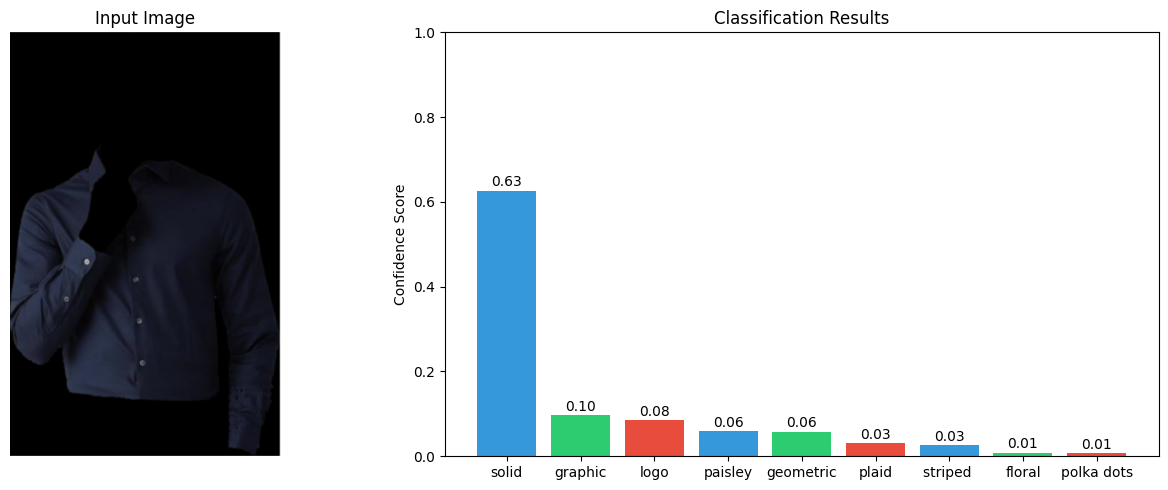

Prediction: solid with 62.65% confidence


In [17]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img_3.png to img_3.png
Processing img_3.png...
similarity : tensor([[0.0265, 0.0041, 0.1344, 0.6514, 0.0708, 0.0223, 0.0142, 0.0606, 0.0161]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.05 seconds


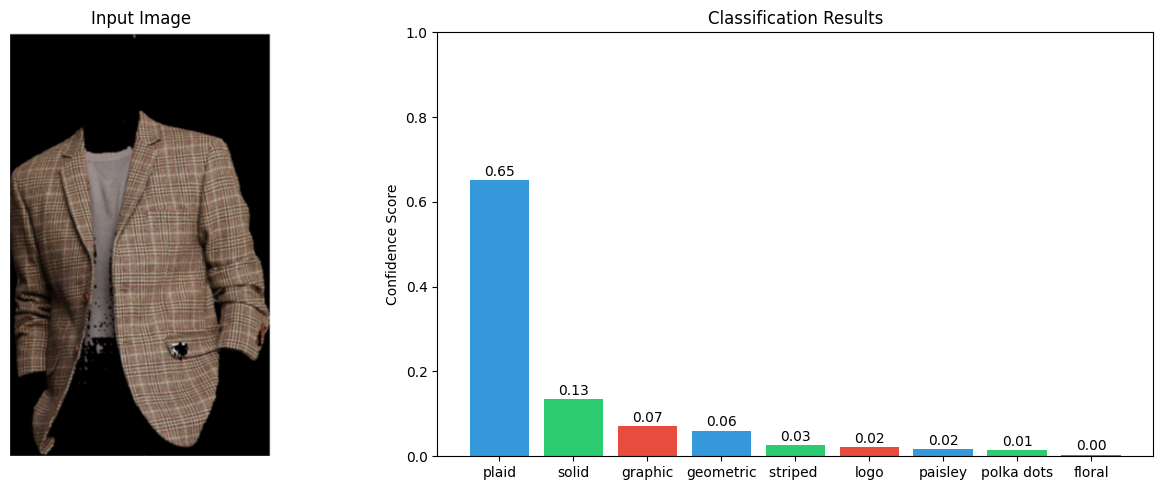

Prediction: plaid with 65.14% confidence


In [18]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img-4.png to img-4.png
Processing img-4.png...
similarity : tensor([[0.0708, 0.0309, 0.4138, 0.0443, 0.1725, 0.0182, 0.0142, 0.0923, 0.1431]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


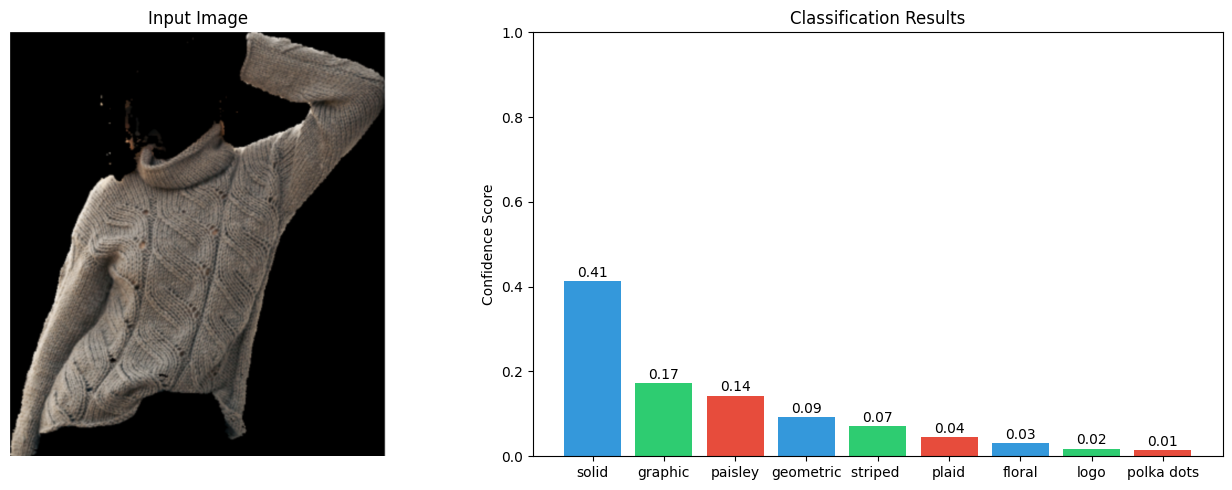

Prediction: solid with 41.38% confidence


In [21]:
upload_and_classify()

In [ ]:
# https://thehouseofrare.com/products/crislon-mens-shirt-black

Please upload an image of an upper-wear garment...


Saving img-5.png to img-5.png
Processing img-5.png...
similarity : tensor([[0.0010, 0.0516, 0.2788, 0.0030, 0.0905, 0.0371, 0.0064, 0.0500, 0.4817]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


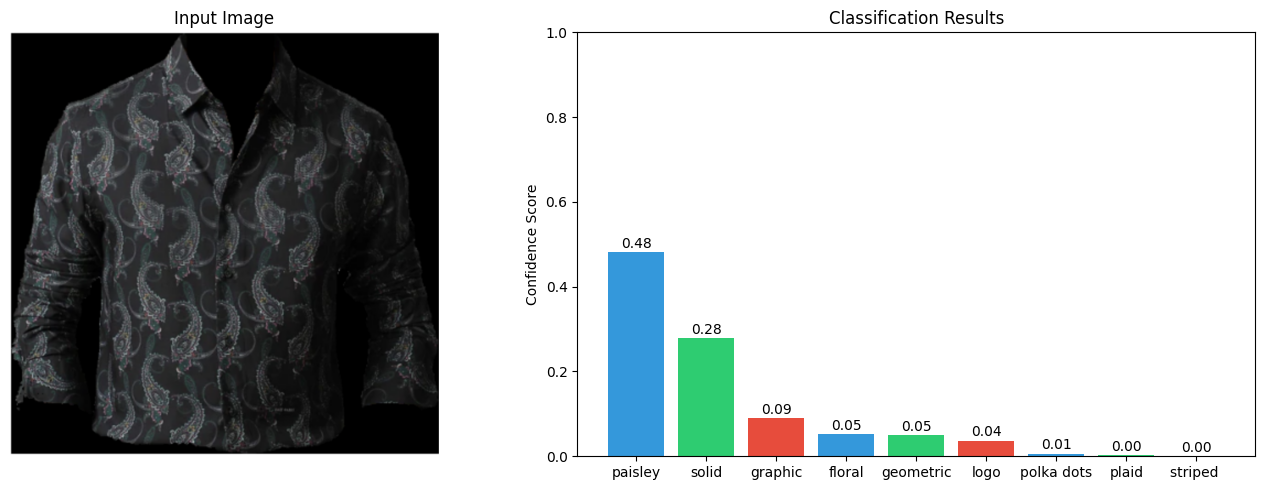

Prediction: paisley with 48.17% confidence


In [22]:
upload_and_classify()

In [24]:
#https://www.muftijeans.in/blue-paisley-print-slim-fit-casual-shirt-mfs-14973-s-blue.html

Please upload an image of an upper-wear garment...


Saving img-6.png to img-6.png
Processing img-6.png...
similarity : tensor([[0.0045, 0.0197, 0.2325, 0.0104, 0.0265, 0.0050, 0.0174, 0.1265, 0.5576]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


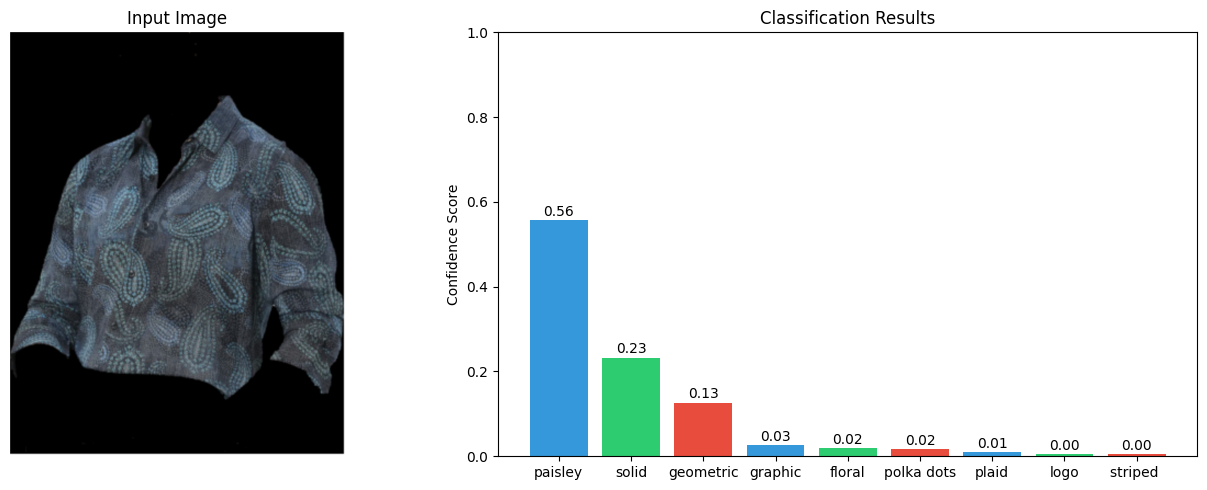

Prediction: paisley with 55.76% confidence


In [23]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img7.png to img7.png
Processing img7.png...
similarity : tensor([[2.5129e-04, 6.4062e-01, 1.2817e-01, 4.6945e-04, 6.5430e-02, 2.2614e-02,
         2.0390e-03, 1.4153e-02, 1.2622e-01]], device='cuda:0',
       dtype=torch.float16)
Classification completed in 1.28 seconds


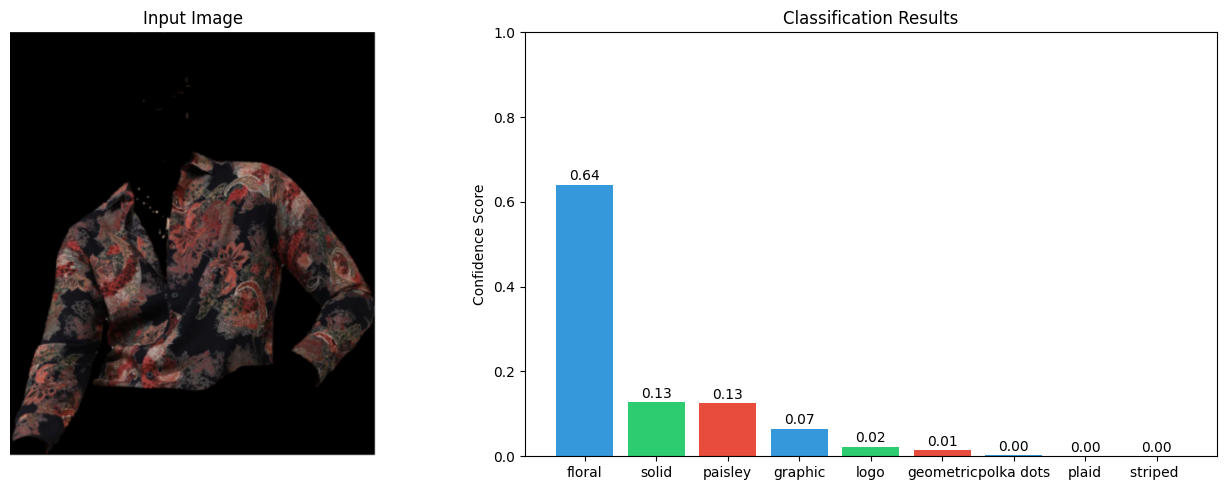

Prediction: floral with 64.06% confidence


In [9]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img8.png to img8.png
Processing img8.png...
similarity : tensor([[4.7970e-04, 6.5479e-01, 9.1431e-02, 2.2182e-03, 3.1586e-02, 3.7155e-03,
         8.3694e-03, 1.4015e-02, 1.9348e-01]], device='cuda:0',
       dtype=torch.float16)
Classification completed in 0.06 seconds


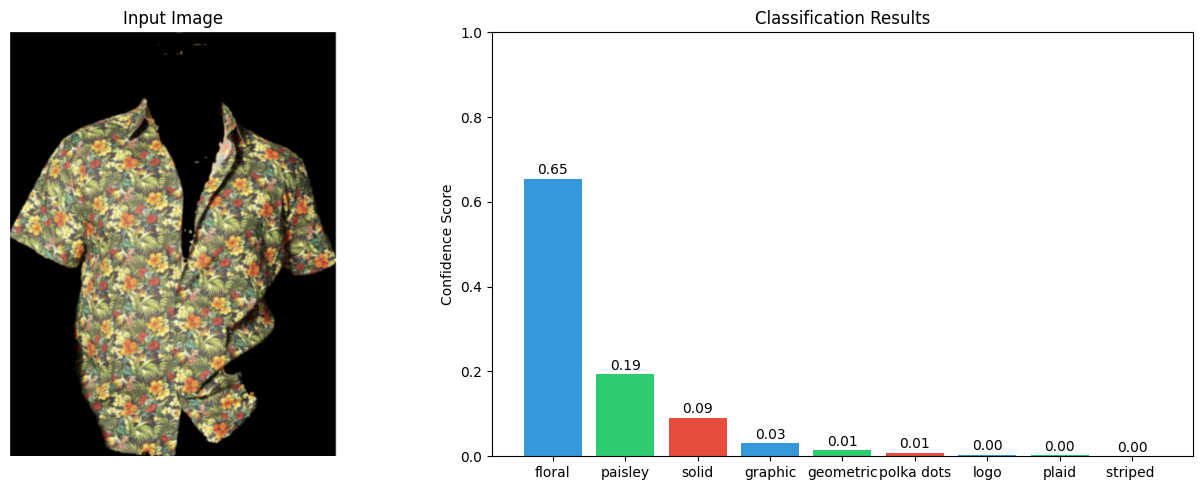

Prediction: floral with 65.48% confidence


In [10]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img-9.png to img-9.png
Processing img-9.png...
similarity : tensor([[0.0042, 0.0008, 0.0930, 0.0010, 0.2032, 0.5522, 0.0109, 0.1312, 0.0032]],
       device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


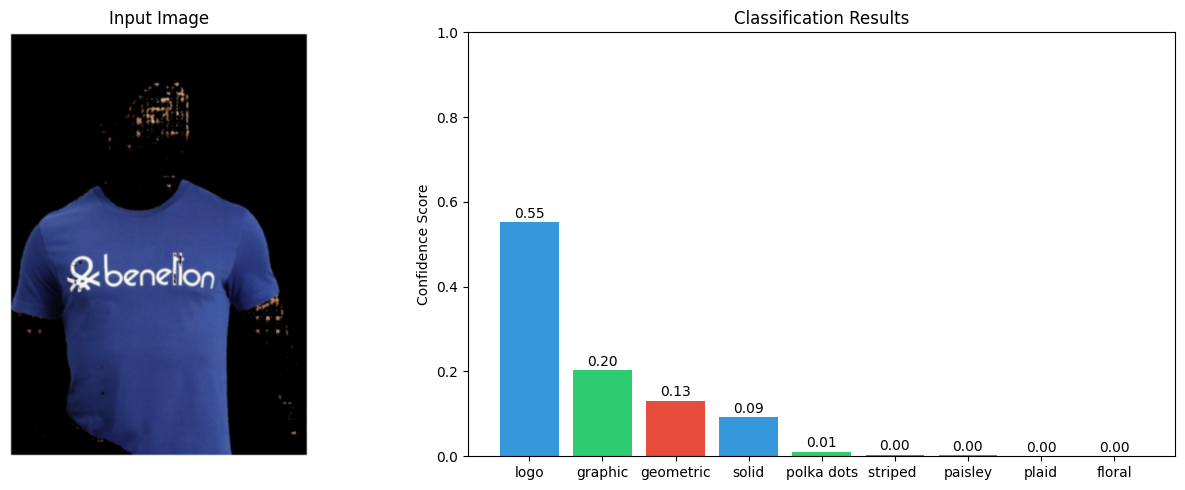

Prediction: logo with 55.22% confidence


In [25]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img_10.png to img_10.png
Processing img_10.png...
similarity : tensor([[8.5938e-01, 7.0238e-04, 5.1605e-02, 1.2848e-02, 3.1799e-02, 1.8692e-02,
         1.0002e-02, 1.2451e-02, 2.4910e-03]], device='cuda:0',
       dtype=torch.float16)
Classification completed in 0.04 seconds


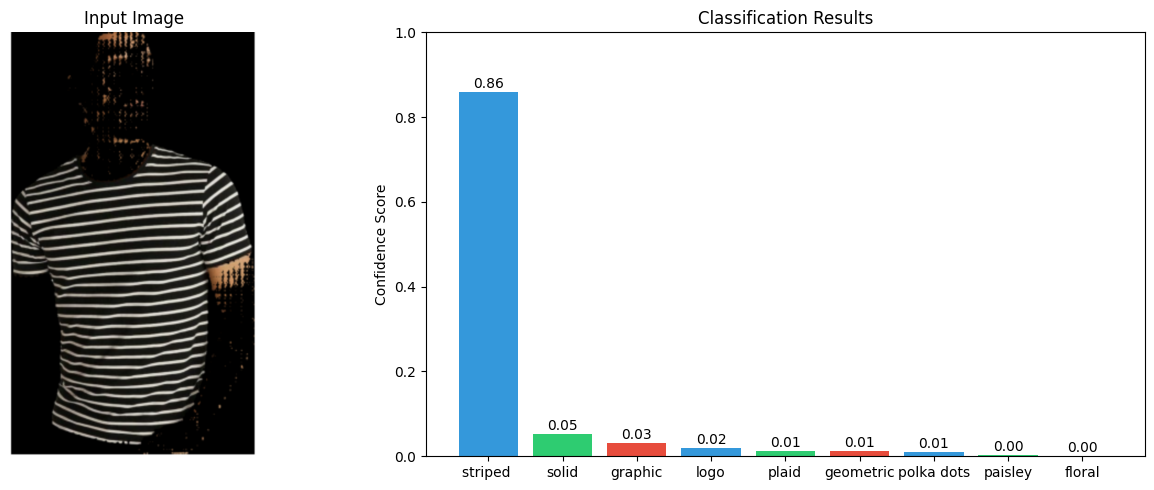

Prediction: striped  with 85.94% confidence


In [27]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img-11.png to img-11.png
Processing img-11.png...
similarity : tensor([[6.5422e-04, 9.2268e-04, 5.0659e-03, 1.9646e-04, 5.2261e-03, 1.1663e-03,
         9.8047e-01, 5.5618e-03, 7.4100e-04]], device='cuda:0',
       dtype=torch.float16)
Classification completed in 0.04 seconds


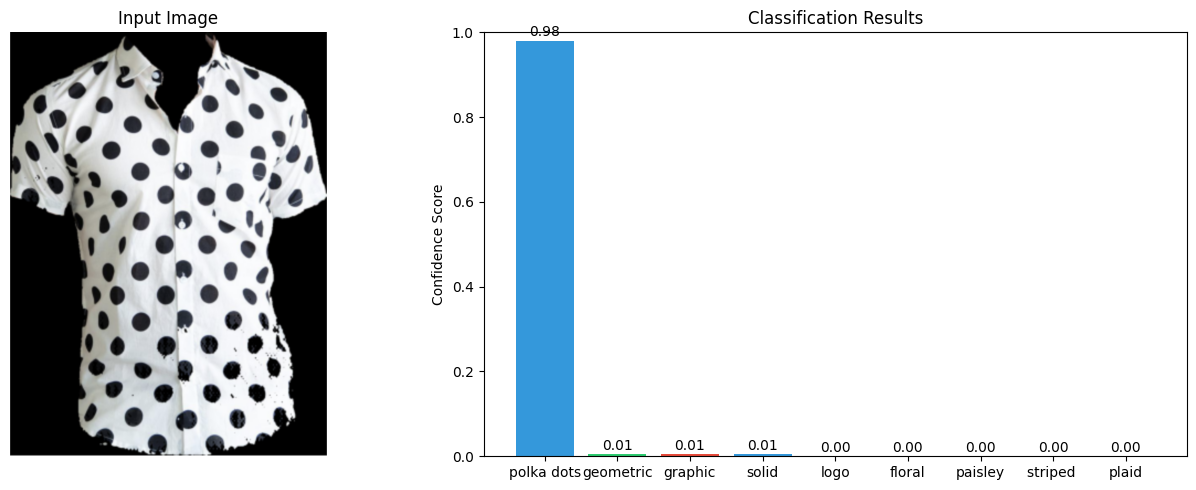

Prediction: polka dots with 98.05% confidence


In [28]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img-12.png to img-12.png
Processing img-12.png...
similarity : tensor([[4.0703e-03, 3.1376e-04, 2.9602e-02, 9.5020e-01, 4.9858e-03, 2.6283e-03,
         9.2268e-04, 6.3057e-03, 8.6641e-04]], device='cuda:0',
       dtype=torch.float16)
Classification completed in 0.04 seconds


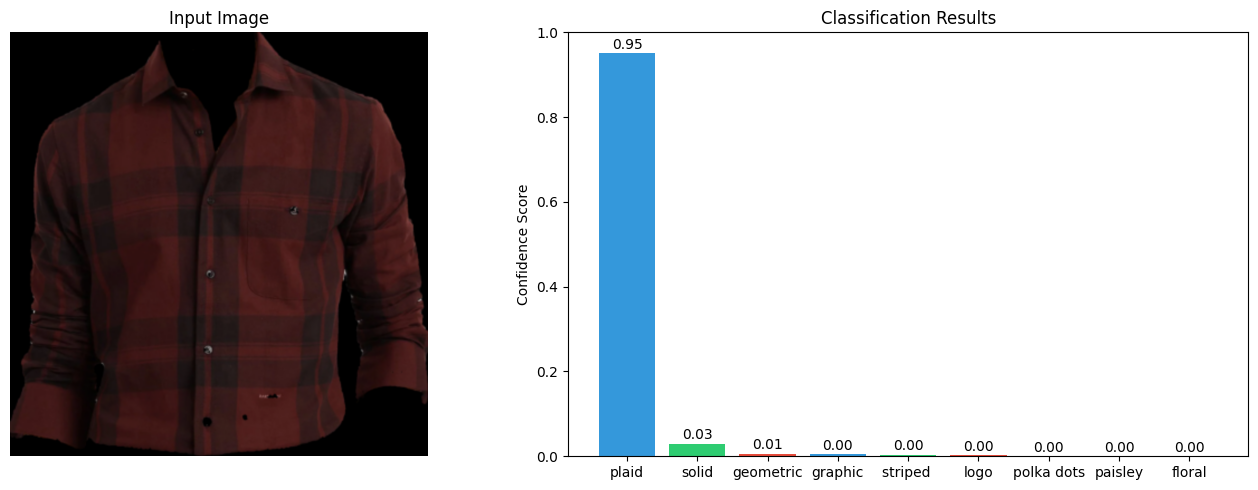

Prediction: plaid with 95.02% confidence


In [29]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img_13.png to img_13.png
Processing img_13.png...
similarity : tensor([[1.8585e-04, 5.5161e-03, 5.3162e-02, 7.5378e-03, 2.1820e-02, 6.1531e-03,
         5.1003e-03, 8.9893e-01, 1.5316e-03]], device='cuda:0',
       dtype=torch.float16)
Classification completed in 0.04 seconds


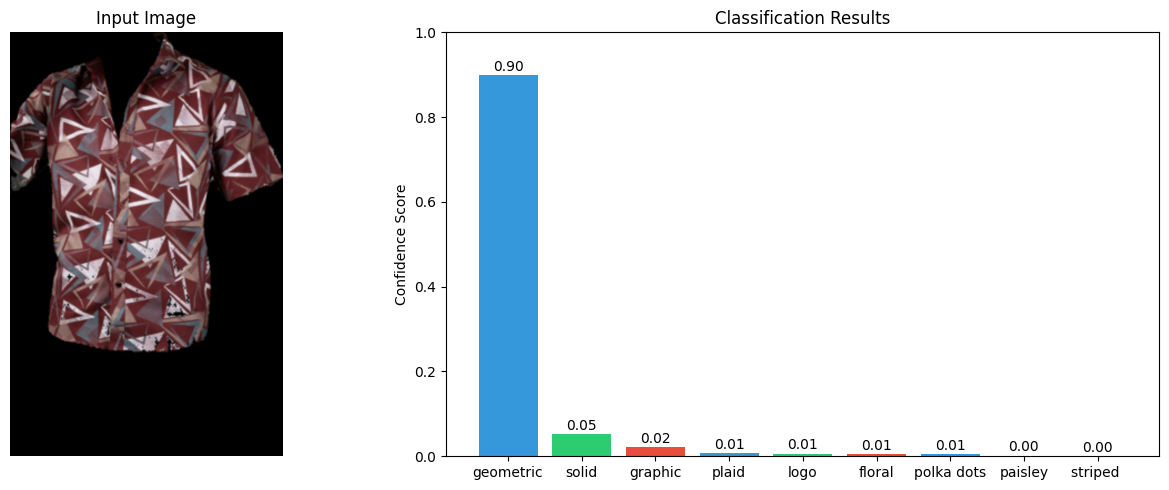

Prediction: geometric with 89.89% confidence


In [31]:
upload_and_classify()